In [2]:
import pennylane as qml # 일반적으로 qml이란 이름으로 가져옵니다. Quantum Machine Learning의 약자입니다.
import numpy as np
import torch

#Part2 A

In [3]:
def embed_rho(rho, total_wires=9, target_wires=4):
    """rho(16x16)를 9qubit 공간(512x512)에 임베딩"""
    dim_total = 2**total_wires
    dim_rho   = 2**target_wires

    big_rho = np.zeros((dim_total, dim_total), dtype=complex)

    # ancilla=|0>, 나머지=|0>으로 두고 앞쪽 4 qubit에만 rho 배치
    for i in range(dim_rho):
        for j in range(dim_rho):
            big_rho[i, j] = rho[i, j]

    return big_rho

In [4]:
def rho_k(rho, k):
    n = int(np.log2(rho.shape[0]))

    rho = rho.astype(np.complex128)
    rho2 = rho.astype(np.complex128)

    for i in range(k-1):
        rho2 = np.kron(rho2, rho).astype(np.complex128)

    proj0 = np.array([[1,0],[0,0]], dtype=np.complex128)
    rho_big = np.kron(rho2, proj0).astype(np.complex128)


    @qml.qnode(qml.device("default.mixed", wires=n*k+1))
    def _2_a(rho_big):

        qml.QubitDensityMatrix(rho_big, wires=range(n*k+1))

        anc = n*k

        qml.H(anc)
        for j in range(k-1):
            for i in range(n):
                qml.CSWAP(wires=[anc, i+j*n, i+(j+1)*n])
        qml.H(anc)

        return qml.expval(qml.PauliZ(anc))

    ans = _2_a(rho_big)
    print(f"Tr(rho^{k}) Quntum:{ans}")

    rho_k = rho
    for i in range(k-1):
        rho_k=rho_k @ rho
    print(f"Tr(rho^{k}) Direct:{np.trace(rho_k).real}")

    return ans

In [5]:
n=3

A = np.random.randn(2**n,2**n) + 1j*np.random.randn(2**n,2**n)
rho = A @ A.conj().T
rho = rho / np.trace(rho)

rho_k(rho, 3)

Tr(rho^3) Quntum:0.06716972032070051
Tr(rho^3) Direct:0.0671697203206996


np.float64(0.06716972032070051)

#Part2 B

In [24]:
import itertools

def haar_unitary(d, rng):
    """Haar 무작위 유니터리 생성 (QR 방식)."""
    Z = (rng.normal(size=(d, d)) + 1j * rng.normal(size=(d, d))) / np.sqrt(2.0)
    Q, R = np.linalg.qr(Z)
    # R의 대각 성분 위상의 보정으로 Haar 분포 확보
    D = np.diag(np.exp(1j * np.angle(np.diag(R))))
    return Q @ D

def classical_shadows_purity(rho, k=2, M=200, seed=0, max_tuples=None):

    rho = np.asarray(rho, dtype=np.complex128)
    d = rho.shape[0]
    assert rho.shape == (d, d)
    # d = 2^n 체크(옵션)
    n_log2 = np.log2(d)
    if abs(n_log2 - round(n_log2)) > 1e-9:
        raise ValueError("rho dimension must be a power of 2.")
    
    @qml.qnode(qml.device("default.mixed", wires=int(n_log2)))
    def _2_b(U, rho):
        qml.QubitDensityMatrix(rho, wires=range(int(n_log2)))
        qml.QubitUnitary(U, wires=range(int(n_log2)))

        return qml.density_matrix(wires=range(int(n_log2)))

    
    d_id = np.eye(d, dtype=np.complex128)

    rng = np.random.default_rng(seed)

    # 1) M개의 shadow 샘플 생성
    shadows = []
    for _ in range(M):
        U = haar_unitary(d, rng)
        
        # sigma = U @ rho @ U.conj().T               # 회전된 상태
        temp = _2_b(U, rho)
        probs = np.real(np.diag(temp))            # 컴퓨테이셔널 기저 확률
        # 수치오차 보정
        probs = np.clip(probs, 0.0, 1.0)
        probs = probs / probs.sum()

        b = rng.choice(d, p=probs)                 # 측정 결과
        e_b = np.zeros((d, 1), dtype=np.complex128)
        e_b[b, 0] = 1.0
        proj_b = e_b @ e_b.conj().T                # |b><b|

        # temp = U.conj().T @ proj_b @ U               # U^\dagger |b><b| U
        temp = _2_b(U.conj().T, proj_b)
        rho_hat = (d + 1) * temp - d_id              # shadow estimator (global 2-design)
        shadows.append(rho_hat)

    all_tuples = list(itertools.combinations(range(M), k))
    if (max_tuples is None) or (max_tuples >= len(all_tuples)):
        idx_tuples = all_tuples
    else:
        chosen = rng.choice(len(all_tuples), size=max_tuples, replace=False)
        idx_tuples = [all_tuples[t] for t in chosen]

    acc = 0.0
    for tup in idx_tuples:
        mat = shadows[tup[0]]
        for idx in tup[1:]:
            mat = mat @ shadows[idx]
        acc += np.trace(mat).real

    return acc / len(idx_tuples)

d = 2
A = np.random.randn(d, d) + 1j*np.random.randn(d, d)
rho = A @ A.conj().T
rho = rho / np.trace(rho)
k=3
est = classical_shadows_purity(rho, k=k, M=400, seed=0)   # 샘플 수 M 늘릴수록 분산 ↓
exact = np.trace(rho @ rho).real

print(f"Classical-shadows estimate Tr(rho^{k}):{est}")
print(f"Exact Tr(rho^{k}):                    {exact}")

Classical-shadows estimate Tr(rho^3):0.8479212081863114
Exact Tr(rho^3):                    0.8767157354350924


#Part2 D

VN entropy

In [7]:
# QMINE-style (QDVR/QMINE) Trainer - fixed
import itertools
import numpy as np
import torch
import pennylane as qml
import matplotlib.pyplot as plt

CDTYPE = torch.complex128
FDTYPE = torch.float64

def one_qubit_mixed_state(p=0.7, device="cpu", dtype=CDTYPE):
    """ρ = p|0><0| + (1-p)|1><1| (표준 계산 기저)"""
    rho = torch.zeros((2,2), dtype=CDTYPE, device=device)
    rho[0,0] = p
    rho[1,1] = 1 - p
    return rho.to(dtype)

class QRDVTrainer_VN:
    def __init__(self, n: int, device: str = "cpu",
                 state_dtype: torch.dtype = CDTYPE,
                 param_dtype: torch.dtype = FDTYPE,
                 dev_name: str = "default.mixed",
                 shots=None):
        self.n = int(n)
        self.device = device
        self.state_dtype = state_dtype
        self.param_dtype = param_dtype

        # PennyLane device (원하면 shots=2000 등으로 NISQ 스타일)
        self._pl_dev = qml.device(dev_name, wires=self.n, shots=shots)

        # Pauli basis (ops/mats/labels)
        self.ops, self.pauli_mats, self.labels = self.make_pauli_basis()

        # 상태/파라미터 캐시
        self.rho = None
        self.exps = None
        self.theta = None
        self.history = []

        # QNode: rho를 "인자"로 받게 정의 (클로저 캡쳐 방지)
        self._expnode = self._build_expnode()

    # ---------- 유틸 ----------
    def normalize_rho(self, rho: torch.Tensor) -> torch.Tensor:
        rho = 0.5 * (rho + rho.conj().T)
        tr = torch.real(torch.trace(rho))
        return (rho / tr).to(self.state_dtype)

    def kron_all(self, mats):
        out = mats[0]
        for m in mats[1:]:
            out = torch.kron(out, m)
        return out

    def make_pauli_basis(self):
        I = torch.tensor([[1,0],[0,1]], dtype=self.state_dtype, device=self.device)
        X = torch.tensor([[0,1],[1,0]], dtype=self.state_dtype, device=self.device)
        Y = torch.tensor([[0,-1j],[1j,0]], dtype=self.state_dtype, device=self.device)  # 복소 유지
        Z = torch.tensor([[1,0],[0,-1]], dtype=self.state_dtype, device=self.device)

        single = [("I", I), ("X", X), ("Y", Y), ("Z", Z)]
        ops, mats, labels = [], [], []

        for choice in itertools.product(single, repeat=self.n):
            lbl = "".join([c[0] for c in choice])
            mats_list = [c[1] for c in choice]
            M = self.kron_all(mats_list)
            mats.append(M)

            obs_terms = []
            for q, (name, _) in enumerate(choice):
                obs_terms.append(
                    qml.Identity(q) if name=="I" else
                    (qml.PauliX(q) if name=="X" else
                     (qml.PauliY(q) if name=="Y" else qml.PauliZ(q)))
                )
            obs = obs_terms[0]
            for t in obs_terms[1:]:
                obs = obs @ t
            ops.append(obs); labels.append(lbl)
        return ops, mats, labels

    def _build_expnode(self):
        n = self.n
        ops = self.ops
        dev = self._pl_dev

        @qml.qnode(dev, interface="torch")
        def circuit(rho_in):
            qml.QubitDensityMatrix(rho_in, wires=range(n))
            return [qml.expval(o) for o in ops]
        return circuit

    # ---------- 모델 구성/손실 ----------
    def build_T(self) -> torch.Tensor:
        """T(θ) = Σ θ_i P_i"""
        T = torch.zeros_like(self.pauli_mats[0], dtype=self.state_dtype, device=self.device)
        for w, M in zip(self.theta, self.pauli_mats):
            T = T + (w.to(self.state_dtype)) * M
        return 0.5 * (T + T.conj().T)

    @staticmethod
    def logtr_expm_from_eig(T: torch.Tensor) -> torch.Tensor:
        evals = torch.linalg.eigvalsh(T)
        m = torch.max(evals)
        return m + torch.log(torch.sum(torch.exp(evals - m)))

    def loss(self):
        """QMINE: L(θ) = -⟨T⟩_ρ + log Tr e^T"""
        first  = - torch.dot(self.theta, self.exps)     # -Σ θ_i <P_i>_ρ
        second = self.logtr_expm_from_eig(self.build_T())
        return first + second, first, second

    # ---------- 학습 ----------
    def train_qmine_entropy(self, rho, steps=300, lr=0.05, seed=2025):
        torch.manual_seed(seed)

        # 1) rho 설정 및 기대값 계산
        self.rho = self.normalize_rho(rho.to(self.state_dtype).to(self.device))
        with torch.no_grad():
            vals = self._expnode(self.rho)                 # list[torch.Tensor]
            self.exps = torch.stack(vals).to(self.param_dtype).to(self.device)

        # 2) θ 초기화
        P = len(self.ops)
        self.theta = torch.zeros(P, dtype=self.param_dtype, device=self.device, requires_grad=True)
        opt = torch.optim.Adam([self.theta], lr=lr)

        # 3) 최적화
        self.history = []
        for t in range(steps):
            opt.zero_grad()
            L, first, second = self.loss()
            L.backward()
            opt.step()
            self.history.append((t+1, float(L), float(first), float(second)))

        return self.theta.detach(), self.labels, self.pauli_mats, self.exps, self.history


S_est ≈ 0.688418,  S_true = 0.673012
Train log (iter, loss, -<T>, logTr exp T):
(50, 0.7113903929897789, -1.6537166426596308, 2.3651070356494097)
(100, 0.6886119123121093, -2.1069479771379465, 2.7955598894500557)


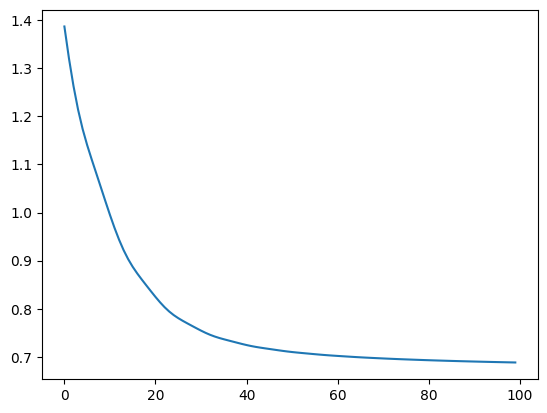

In [8]:
# ## pure state
# rho1 = one_qubit_mixed_state(p=0)
# rho1 = one_qubit_mixed_state(p=1)
# rho1 = torch.tensor(np.kron(rho1,rho1))
# print(rho1)

# ## mixed state
# rho1 = one_qubit_mixed_state(p=np.random.random())
# rho1 = torch.tensor(np.kron(rho1,rho1))

## low rank state
ket0 = torch.tensor([[1.0],[0.0],[0.0],[0.0]], dtype=torch.complex128)  # |00>
ket1 = torch.tensor([[0.0],[1.0],[0.0],[0.0]], dtype=torch.complex128)  # |01>
rho01 = ket0 @ ket0.conj().T
rho02 = ket1 @ ket1.conj().T
rho1 = 0.6 * rho01 + 0.4 * rho02



trainer = QRDVTrainer_VN(n=2, device="cpu")
theta1, labels1, mats1, exps1, hist1 = trainer.train_qmine_entropy(rho=rho1, steps=100, lr=0.05)

# Estimated entropy from optimized θ:
T1 = trainer.build_T()
S1_est = (- torch.dot(theta1, exps1) + trainer.logtr_expm_from_eig(T1)).item()

# Ground-truth S(ρ) (classical)
evals1 = torch.linalg.eigvalsh(rho1).real
S1_true = (- (evals1 * torch.log(evals1 + 1e-12)).sum()).item()

print("S_est ≈ %.6f,  S_true = %.6f" % (S1_est, S1_true))
print("Train log (iter, loss, -<T>, logTr exp T):")
for row in hist1:
    if row[0]%50 == 0:
        print(row)

plt.plot([row[1] for row in hist1])


Renyi entropy

In [9]:
# QMINE-style (QDVR/QMINE) Trainer - fixed
import itertools
import numpy as np
import torch
import pennylane as qml
import matplotlib.pyplot as plt
import math

CDTYPE = torch.complex128
FDTYPE = torch.float64

def one_qubit_mixed_state(p=0.7, device="cpu", dtype=CDTYPE):
    """ρ = p|0><0| + (1-p)|1><1| (표준 계산 기저)"""
    rho = torch.zeros((2,2), dtype=CDTYPE, device=device)
    rho[0,0] = p
    rho[1,1] = 1 - p
    return rho.to(dtype)

class QRDVTrainerRenyi:
    def __init__(self, n: int, device: str = "cpu",
                 state_dtype: torch.dtype = CDTYPE,
                 param_dtype: torch.dtype = FDTYPE,
                 dev_name: str = "default.mixed",
                 shots=None):
        self.n = int(n)
        self.device = device
        self.state_dtype = state_dtype
        self.param_dtype = param_dtype

        # PennyLane device (원하면 shots=2000 등으로 NISQ 스타일)
        self._pl_dev = qml.device(dev_name, wires=self.n, shots=shots)

        # Pauli basis (ops/mats/labels)
        self.ops, self.pauli_mats, self.labels = self.make_pauli_basis()

        # 상태/파라미터 캐시
        self.rho = None
        self.exps = None
        self.theta = None
        self.history = []

        self.S = None          # shape (2^n, P_ZI)
        self.labels_ZI = None  # Z/I 라벨
        self.mats_ZI = None    # Z/I 매트릭스(안 써도 보관)

        # QNode: rho를 "인자"로 받게 정의 (클로저 캡쳐 방지)
        self._expnode = self._build_expnode()

    # ---------- 유틸 ----------
    def normalize_rho(self, rho: torch.Tensor) -> torch.Tensor:
        rho = 0.5 * (rho + rho.conj().T)
        tr = torch.real(torch.trace(rho))
        return (rho / tr).to(self.state_dtype)

    def kron_all(self, mats):
        out = mats[0]
        for m in mats[1:]:
            out = torch.kron(out, m)
        return out
    
    def make_pauli_basis(self):
        I = torch.tensor([[1,0],[0,1]], dtype=self.state_dtype, device=self.device)
        X = torch.tensor([[0,1],[1,0]], dtype=self.state_dtype, device=self.device)
        Y = torch.tensor([[0,-1j],[1j,0]], dtype=self.state_dtype, device=self.device)  # 복소 유지
        Z = torch.tensor([[1,0],[0,-1]], dtype=self.state_dtype, device=self.device)

        single = [("I", I), ("X", X), ("Y", Y), ("Z", Z)]
        ops, mats, labels = [], [], []

        for choice in itertools.product(single, repeat=self.n):
            lbl = "".join([c[0] for c in choice])
            mats_list = [c[1] for c in choice]
            M = self.kron_all(mats_list)
            mats.append(M)

            obs_terms = []
            for q, (name, _) in enumerate(choice):
                obs_terms.append(
                    qml.Identity(q) if name=="I" else
                    (qml.PauliX(q) if name=="X" else
                     (qml.PauliY(q) if name=="Y" else qml.PauliZ(q)))
                )
            obs = obs_terms[0]
            for t in obs_terms[1:]:
                obs = obs @ t
            ops.append(obs); labels.append(lbl)
        return ops, mats, labels

    def make_pauli_basis_ZI(self):
        Z = torch.tensor([[1,0],[0,-1]], dtype=self.state_dtype, device=self.device)
        I = torch.tensor([[1,0],[0, 1]], dtype=self.state_dtype, device=self.device)
        single = [("I", I), ("Z", Z)]
        mats, labels = [], []
        for choice in itertools.product(single, repeat=self.n):
            lbl = "".join([c[0] for c in choice])
            mats_list = [c[1] for c in choice]
            M = self.kron_all(mats_list)
            mats.append(M); labels.append(lbl)
        return mats, labels
    
    def sign_table_ZI(self, labels):
        d = 2**self.n
        S = torch.empty((d, len(labels)), dtype=self.param_dtype, device=self.device)
        for x in range(d):
            bits = [(x >> k) & 1 for k in range(self.n)]
            bits = list(reversed(bits))  # MSB..LSB
            row = []
            for lbl in labels:
                s = 1.0
                for b, ch in zip(bits, lbl):
                    if ch == 'Z':
                        s *= (1.0 if b == 0 else -1.0)
                row.append(s)
            S[x,:] = torch.tensor(row, dtype=self.param_dtype, device=self.device)
        return S
    
    def ensure_commuting_tables(self):
        """Z/I 모드용 라벨/사인테이블 준비"""
        if self.S is None:
            self.mats_ZI, self.labels_ZI = self.make_pauli_basis_ZI()
            self.S = self.sign_table_ZI(self.labels_ZI)

    def _build_expnode(self):
        n = self.n
        ops = self.ops
        dev = self._pl_dev

        @qml.qnode(dev, interface="torch")
        def circuit(rho_in):
            qml.QubitDensityMatrix(rho_in, wires=range(n))
            return [qml.expval(o) for o in ops]
        return circuit

    # ---------- 모델 구성/손실 ----------
    def build_T(self) -> torch.Tensor:
        """T(θ) = Σ θ_i P_i"""
        T = torch.zeros_like(self.pauli_mats[0], dtype=self.state_dtype, device=self.device)
        for w, M in zip(self.theta, self.pauli_mats):
            T = T + (w.to(self.state_dtype)) * M
        return 0.5 * (T + T.conj().T)

    @staticmethod
    def _logsumexp(x: torch.Tensor) -> torch.Tensor:
        m = torch.max(x)
        return m + torch.log(torch.sum(torch.exp(x - m)))

    def loss(self, alpha):
        """Renyi"""
        self.ensure_commuting_tables()
        T_diag = self.S @ self.theta                       # (d,)
        rho_diag = torch.real(torch.diagonal(self.rho)).clamp(min=0)  # (d,)
        eps = 1e-20
        term1 = (alpha/(alpha-1.0)) * torch.log(torch.sum(torch.exp((alpha-1.0)*T_diag) * (rho_diag + eps)))
        term2 = torch.log(torch.sum(torch.exp(alpha*T_diag))) - math.log(2**self.n)
        L = term1 - term2
        return -L, L.detach(), term1.detach(), term2.detach()

    # ---------- 학습 ----------
    def train_qmine_entropy(self, rho, alpha=2, steps=300, lr=0.05, seed=2025):
        torch.manual_seed(seed)

        # 1) rho 설정 및 기대값 계산
        self.rho = self.normalize_rho(rho.to(self.state_dtype).to(self.device))
        with torch.no_grad():
            vals = self._expnode(self.rho)                 # list[torch.Tensor]
            self.exps = torch.stack(vals).to(self.param_dtype).to(self.device)

        # 2) θ 초기화
        self.ensure_commuting_tables()
        P = self.S.shape[1] 
        self.theta = (1e-3 * torch.randn(P, dtype=self.param_dtype, device=self.device)).requires_grad_()
        opt = torch.optim.Adam([self.theta], lr=lr)

        # 3) 최적화
        self.history = []
        for t in range(steps):
            opt.zero_grad()
            loss_min, L, term1, term2 = self.loss(alpha)
            loss_min.backward()
            opt.step()
            self.history.append((t+1, float(L), float(term1), float(term2)))

        return self.theta.detach(), self.labels, self.pauli_mats, self.exps, self.history


tensor([[0.0552+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.1798+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.1798+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.5852+0.j]],
       dtype=torch.complex128)
S_est ≈ 0.824958,  S_true = 0.824928
Train log (step, L_alpha, term1, term2):
(50, 0.5602355353956827, 2.005899437173146, 1.4456639017774633)
(100, 0.5613256723335354, 2.187685071149094, 1.6263593988155585)


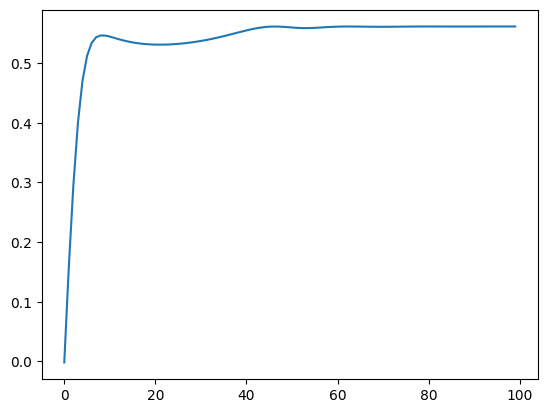

In [10]:
## pure state
# rho1 = one_qubit_mixed_state(p=0)
# rho1 = one_qubit_mixed_state(p=1)
# rho1 = torch.tensor(np.kron(rho1,rho1))

## mixed state
rho1 = one_qubit_mixed_state(p=np.random.random())
rho1 = torch.tensor(np.kron(rho1,rho1))

## low rank state
# ket0 = torch.tensor([[1.0],[0.0],[0.0],[0.0]], dtype=torch.complex128)  # |00>
# ket1 = torch.tensor([[0.0],[1.0],[0.0],[0.0]], dtype=torch.complex128)  # |01>
# rho01 = ket0 @ ket0.conj().T
# rho02 = ket1 @ ket1.conj().T
# rho1 = 0.6 * rho01 + 0.4 * rho02

print(rho1)

trainer = QRDVTrainerRenyi(n=2, device="cpu")
alpha=2.5
theta1, labels1, mats1, exps1, hist1 = trainer.train_qmine_entropy(rho=rho1, alpha=alpha, steps=100, lr=0.05)

# Estimated entropy from optimized θ:
d = 2 ** trainer.n
best_L = max(row[1] for row in hist1)   # hist1: (step, L, term1, term2)
S1_est = math.log(d) - best_L

# Ground-truth S_a(ρ) (classical)
ev = torch.linalg.eigvalsh(trainer.rho).real.clamp(min=0)
ev = ev / ev.sum()
S1_true = (1.0/(1.0-alpha)) * torch.log((ev**alpha).sum() + 1e-20)
S1_true = float(S1_true)



if(abs(round(alpha)-alpha) < 1e-9):
    S1_swap = 1/(1-alpha)*np.log(rho_k(rho1.cpu().numpy(), alpha))
    print("S_est ≈ %.6f,  S_true = %.6f,  S_swap = %.6f" % (S1_est, S1_true, S1_swap))
else:
    print("S_est ≈ %.6f,  S_true = %.6f" % (S1_est, S1_true))
print("Train log (step, L_alpha, term1, term2):")
for row in hist1:
    if row[0]%50 == 0:
        print(row)

plt.plot([row[1] for row in hist1])
